In [1]:
import cv2
import numpy as np
import os
import random as rd
import matplotlib.pyplot as plt

In [2]:
def readImages(directory):
    images_name = []
    images = []
    images_r, images_g, images_b = [], [], []
    images_rgb = [images_r, images_g, images_b]
    for filename in os.listdir(directory):
        images_name.append( directory + '/' + filename)
    images_name = sorted(images_name)
    for i in images_name:
        images.append(cv2.imread(i))
        b, g, r = cv2.split(images[-1])
        images_r.append(np.array(r))
        images_g.append(np.array(b))
        images_b.append(np.array(g))
        # cv2.imwrite("img.png", cv2.merge((b,g,r)))
        # images_rgb.append(cv2.cvtColor(images[-1], cv2.COLOR_BGR2RGB))
    images_r, images_g, images_b = np.array(images_r), np.array(images_g), np.array(images_b)
    return images, images_rgb

In [3]:
def sampleZ(images_1c, MAX_intensity):
    images = images_1c
    intensity_range = MAX_intensity + 1
    Z = np.zeros((intensity_range, len(images)), dtype = int)
    # src_img = images[rd.randrange(len(images))]
    src_img = images[len(images) // 2]
    for intensity in range(intensity_range):
        rows, cols = np.where(src_img == intensity)
        if(len(rows) == 0):
            rows, cols = np.where(images[len(images) // 2 + 1] == intensity)
            if(len(rows) == 0):
                continue
        idx = rd.randrange(len(rows))
        r, c = rows[idx], cols[idx]
        for img_idx in range(len(images)):
            Z[intensity, img_idx] = images[img_idx][r][c]
    return Z


In [4]:
def intensity_weighting(pix_value, MAX_intensity):
    return(min(pix_value, MAX_intensity - pix_value))

In [5]:
def intensityAdjustment(image, template):
    g, b, r = cv2.split(image)
    tg, tb, tr = cv2.split(template)
    b *= np.average(tb) / np.nanmean(b)
    g *= np.average(tg) / np.nanmean(g)
    r *= np.average(tr) / np.nanmean(r)
    # image = np.average(template) / np.nanmean(image) * image
    image = cv2.merge((g,b,r))
    return image
# intensityAdjustment(output, images[len(images) // 2])

In [6]:
from tqdm import tqdm_notebook as tqdm
def radiance_map_1c(images_1c, shutter_times, response_curve, weighting_function):
    images = images_1c;
    rad_map = np.zeros(images[0].shape);
    
    for i in tqdm(range(len(images[0]))):
        for j in range(len(images[0][0])):
            g = np.array( [response_curve[images[n][i][j]] for n in range(len(images))] )
            w = np.array( [weighting_function(images[n][i][j], 255) for n in range(len(images))] )
            SumW = np.sum(w)
            if SumW > 0:
                rad_map[i][j] = np.sum(w * (g - shutter_times) / SumW)
            else:
                idx = rd.randrange(len(images))
                rad_map[i][j] = g[idx] - shutter_times[idx]
    return rad_map

In [7]:
def show_images(images):
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    for p in range(len(images)):
        r = int(p / 4)
        c = int(p % 4)
        axes[r][c].imshow(images[p])
    plt.show()

In [8]:
def computeResponseCurve(intensity_samples, log_exposures, smoothing_lambda, weighting_function):
    z_min, z_max = 0, 255
    intensity_range = 255  # difference between min and max possible pixel value for uint8
    num_samples = intensity_samples.shape[0]
    num_images = len(log_exposures)

    # NxP + [(Zmax-1) - (Zmin + 1)] + 1 constraints; N + 256 columns
    mat_A = np.zeros((num_images * num_samples + intensity_range, num_samples + intensity_range + 1), dtype=np.float64)
    mat_b = np.zeros((mat_A.shape[0], 1), dtype=np.float64)

    # 1. Add data-fitting constraints:
    k = 0
    for i in range(num_samples):
        for j in range(num_images):
            z_ij = intensity_samples[i, j]
            w_ij = weighting_function(z_ij, 255)
            mat_A[k, z_ij] = w_ij
            mat_A[k, (intensity_range + 1) + i] = -w_ij
            mat_b[k, 0] = w_ij * log_exposures[j]
            k += 1
    
    # 2. Add smoothing constraints:
    for z_k in range(z_min + 1, z_max):
        w_k = weighting_function(z_k, 255)
        mat_A[k, z_k - 1] = w_k * smoothing_lambda
        mat_A[k, z_k    ] = -2 * w_k * smoothing_lambda
        mat_A[k, z_k + 1] = w_k * smoothing_lambda
        k += 1

    # 3. Add color curve centering constraint:
    mat_A[k, (z_max - z_min) // 2] = 1
    
    inv_A = np.linalg.pinv(mat_A)
    x = np.dot(inv_A, mat_b)
   
    g = x[0: intensity_range + 1]
    return g[:, 0]


In [9]:
def gammaToneMapping(image):
    gamma = 0.8
    image_corrected = cv2.pow(image/255., 1.0/gamma)
    return image_corrected

In [56]:
#import numpy as np
#from random import random
#from tqdm import tqdm
from matplotlib import pyplot as plt
from PIL import Image

def gaussian(x, sigma):
    return (1.0 / (2 * np.pi * (sigma ** 2))) * np.exp(- (x ** 2) / (2 * sigma ** 2))


def bilateral_filter(input_image, output_image, x, y, filter_size):
    w_sum = 0
    denoised_intensity = 0
    sigma_r = 1000
    sigma_d = 2000
    h = input_image.shape[0]
    w = input_image.shape[1]
    for i in range(-filter_size, filter_size + 1):
        for j in range(-filter_size, filter_size + 1):
            if x + i >= h or x + i < 0 or y + j >= w or y + j < 0:
                continue
            fr = gaussian(input_image[x + i][y + j] - input_image[x][y], sigma_r)
            gs = gaussian(np.linalg.norm([i, j]), sigma_d)
            w =  fr * gs
            denoised_intensity += w * input_image[x + i][y + j]
            w_sum += w
    denoised_intensity /= w_sum
    #print(denoised_intensity)
    return denoised_intensity
    #print(output_image[x, y])

def bilateral(input_image):
    filter_size = 2
    output_image = np.zeros(input_image.shape)
    h = input_image.shape[0]
    w = input_image.shape[1]
    for i in range(h):
        for j in range(w):
            output_image[i, j] = bilateral_filter(input_image, output_image,i, j, filter_size)
            #print(output_image[i, j])
    return output_image

def bilateral_func(input_image):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    R = input_image[0]
    G = input_image[2]
    B = input_image[1]
    #intensity = 1/61 * (20 * R + 40 * G + B)
    intensity = 0.2126 * R + 0.7152 * G + 0.0722 * B
    print('intensity array ', intensity)
    axes[0][0].imshow(Image.fromarray(intensity))
    r = R / intensity
    g = G / intensity
    b = B / intensity
    log_intensity = np.log(intensity)
    log_base = bilateral(log_intensity)
    log_detail = log_intensity - log_base
    print('base array',log_base)
    print('detail array',log_detail)
    axes[0][1].imshow(Image.fromarray(np.exp(log_base)))
    axes[1][0].imshow(Image.fromarray(np.exp(log_detail)))
    targetContrast = np.log10(5)
    tragetContrast = 20
    compressionfactor = targetContrast / (np.max(log_base) - np.min(log_base))
    print('compressionfactor',compressionfactor)
    compressionfactor = 0.85
    log_abs_scale = np.max(log_base) * compressionfactor
    print('log absolute scale', log_abs_scale)
    log_output = log_base * compressionfactor + log_detail# - log_abs_scale
    axes[1][1].imshow(Image.fromarray(np.exp(log_output)))
    print('log output', log_output)
    R_out = r * np.exp(log_output)
    G_out = g * np.exp(log_output)
    B_out = b * np.exp(log_output)
    plt.show()
    return [R_out, B_out, G_out]#np.concatenate((R_out, G_out, B_out), axis = 2)

In [58]:
# if RadMap hasn't been calculated, send RadMap = []
def CreateHdrImage(images_rgb, MAX_intensity, shutter_times, WeightedIntensity, ToneMappingFunction, RadMap):
    Z_rgb, RespCurve, output = [], [], []
    SLambda = 10
    
    # intensity sampling
    Z_rgb = list(map(sampleZ, images_rgb, [MAX_intensity] * 3))
    
    # response curve
    RespCurve = list(map(computeResponseCurve, Z_rgb, [shutter_times] * 3, [SLambda] * 3, [WeightedIntensity] * 3))
    #RespCurve = [-1 * curve for curve in RespCurve]
    plt.plot(RespCurve[0])
    plt.plot(RespCurve[1])
    plt.plot(RespCurve[2])
    plt.show()
    # Calculate Radiance Map if RadMap is an empty list
    if len(RadMap) == 0:
        RadMap = list(map(radiance_map_1c, images_rgb, [shutter_times] * 3, RespCurve, [WeightedIntensity] * 3))
    
    # normalize and Tonemapping
    for i in range(3):
        output.append(cv2.normalize(np.exp(RadMap[i]), np.array([]), alpha=0, beta=255, norm_type=cv2.NORM_MINMAX))
    #output = list(map(ToneMappingFunction, output))
    output = bilateral_func(output)
    for i in range(3):
        output[i] = cv2.normalize(output[i], np.array([]), alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    result_image = cv2.merge((output[1], output[2], output[0]))
    
    # intensity adjustment
    result_image= intensityAdjustment(result_image, images[4])
    
    return result_image, RadMap

In [11]:
# balcony_times = np.array([1/400, 1/250, 1/100, 1/40, 1/25, 1/8, 1/3], dtype = float)
# memorial_list = [ 2 ** 10, 2 ** 9, 2 ** 8, 2 ** 7, 
#                  2 ** 6, 2 ** 5, 2 ** 4, 2 ** 3, 
#                  2 ** 2, 2 ** 1, 2 ** (0), 2 ** (-1), 
#                  2 ** (-2), 2 ** (-3), 2 ** (-4), 2 ** (-5)]
# memorial_times = np.array(shutter_list, dtype=np.float32)
# living_room_times = np.array([1/160, 1/125, 1/80, 1/60, 1/40, 1/15], dtype = float)

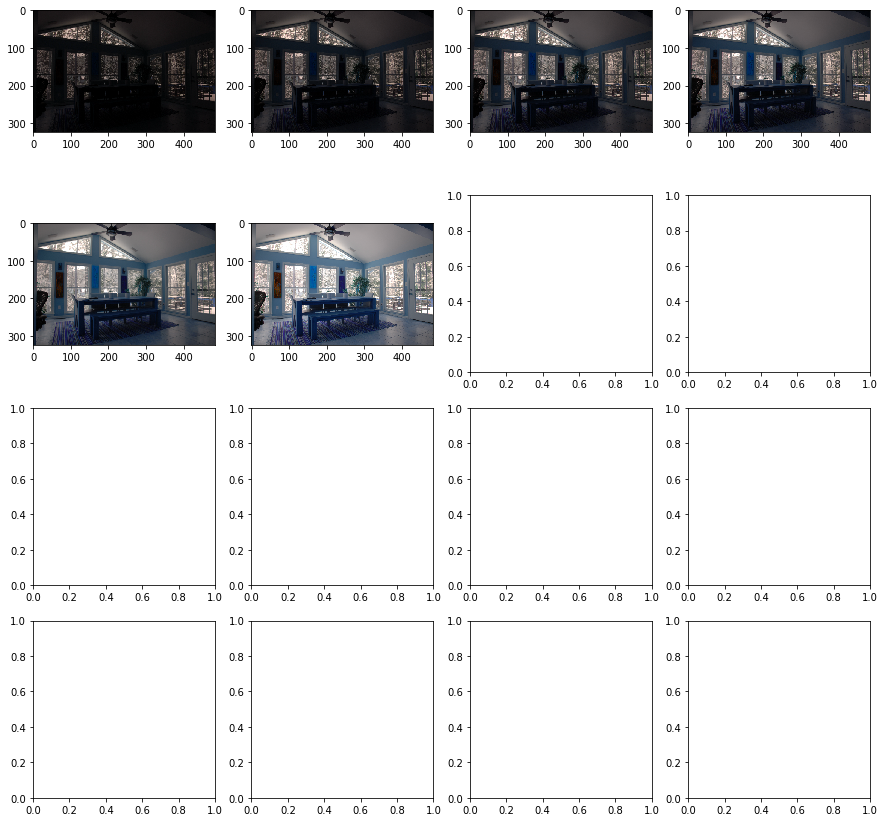

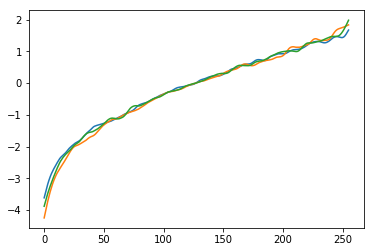

intensity array  [[5.6335589  5.59384023 5.73738576 ... 1.00947805 0.98492854 0.91496482]
 [5.68670444 5.8241188  5.82203583 ... 1.0620103  1.0009173  0.97171607]
 [5.93332516 5.97874452 5.95157212 ... 1.08549474 0.94806137 0.98299478]
 ...
 [3.14172061 3.26961983 3.23950129 ... 5.98588017 5.49464746 5.68686246]
 [3.11809395 3.18310795 3.22627607 ... 5.93870455 5.53311392 5.48868719]
 [3.16842076 3.15015212 3.28087043 ... 5.36767705 5.19015402 5.1802071 ]]
base array [[1.74915235 1.74915235 1.74915235 ... 0.09303045 0.03669096 0.00943342]
 [1.76167606 1.76167606 1.76167606 ... 0.09303045 0.03669096 0.00943342]
 [1.77082047 1.77082047 1.77082047 ... 0.09303045 0.03669096 0.00943342]
 ...
 [1.15387046 1.15387046 1.15387046 ... 1.81448998 1.84059721 1.77316235]
 [1.15070568 1.15070568 1.15070568 ... 1.78212452 1.81659492 1.83574836]
 [1.14507527 1.14507527 1.14507527 ... 1.80867003 1.78028672 1.78940339]]
detail array [[-2.04109747e-02 -2.74863164e-02 -2.14868528e-03 ... -8.35970292e-02
 

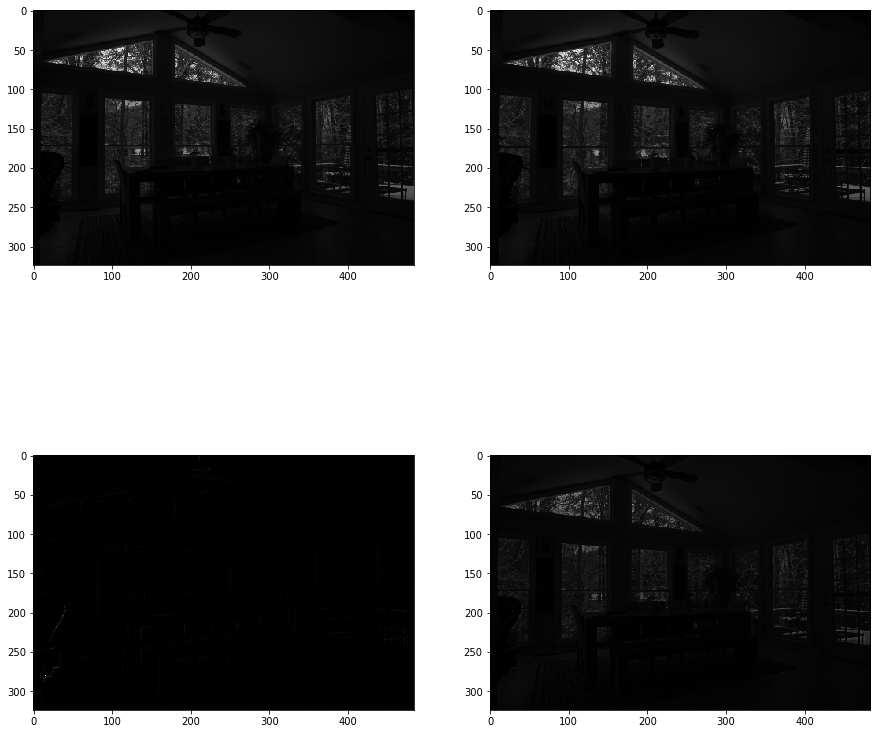

In [61]:
if __name__ == "__main__":
    images, images_rgb = readImages("testing_images/living_room_images")
    show_images(images)
    living_room_times = np.array([1/160, 1/125, 1/80, 1/60, 1/40, 1/15], dtype = float)
    
    #test_times = np.array([60, 80, 100, 125, 160, 200, 250, 320, 400, 500, 800, 1250, 2000, 3200], dtype = float)
    #test_times = test_times[::-1]
    #living_room_times = np.array([32, 16, 8, 4, 2, 1, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.15625, 0.0078125, 0.00390625, 0.001953125, 0.0009765265], dtype = float)
    #living_room_times = living_room_times[::-1]
    living_room_times = np.log(living_room_times)
    result_image, RadianceMap = CreateHdrImage(
                                   images_rgb, 
                                   MAX_intensity = 255, 
                                   shutter_times = living_room_times,#test_times[-10: -1], 
                                   WeightedIntensity = intensity_weighting, 
                                   ToneMappingFunction = gammaToneMapping, 
                                   RadMap = []
                                )
    
    cv2.imwrite("result_images/living room test tone mapping.png", result_image)

In [55]:
np.exp(np.max(RadianceMap))

107.3439862817477